# DeepHit

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import torch
import torchtuples as tt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss
from pycox.models import DeepHitSingle
from pycox.models.loss import DeepHitLoss
from pycox.evaluation import EvalSurv
from torchtuples.callbacks import Callback
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'torch',
    'torchtuples',
    'pycox',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))

dfp = df.to_pandas()
dfp_nn = dfp.dropna()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 1.5.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
torch version: 1.13.1
torchtuples version: 0.2.2
pycox version: 0.3.0
sksurv version: 0.21.0
sklearn version: 1.2.2
scipy version: 1.13.1


In [179]:
X = dfp_nn.drop(columns=["time", "event"])
T = dfp_nn["time"].to_numpy().astype('float32')
E = dfp_nn["event"].to_numpy().astype('bool')

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.to_numpy().astype('float32'))

# Train-test split
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(X_scaled, T, E, test_size=0.2, random_state=0)
X_train, X_val, T_train, T_val, E_train, E_val = train_test_split(X_train, T_train, E_train, test_size=0.2, random_state=0)


# Label transformation
num_durations = 21
labtrans = DeepHitSingle.label_transform(num_durations)
Y_train = labtrans.fit_transform(T_train, E_train)
Y_val = labtrans.fit_transform(T_val, E_val)
Y_test = labtrans.transform(T_test, E_test)

in_features = X_train.shape[1]
net = tt.practical.MLPVanilla(
    in_features, [64, 32],
    out_features=labtrans.out_features,
    batch_norm=True,
    dropout=0.1,
    activation=torch.nn.Sigmoid
)
optimizer = tt.optim.Adam(lr=15e-3)
model = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts, alpha=0.2, sigma=0.3)

class CustomLRScheduler(Callback):
    def __init__(self, optimizer, decay=0.95, min_lr=1e-5):
        super().__init__()
        self.optimizer = optimizer
        self.decay = decay
        self.min_lr = min_lr

    def on_epoch_end(self):
            for i, param_group in enumerate(self.optimizer.param_groups):
                old_lr = param_group['lr']
                new_lr = max(self.min_lr, old_lr * self.decay)
                param_group['lr'] = new_lr

lr_callback = CustomLRScheduler(optimizer, decay=0.96)

callbacks = [
    lr_callback,
    tt.callbacks.EarlyStopping(patience=20),
]

start_time = time.time()
log = model.fit(X_train, Y_train, batch_size=1024, epochs=50, verbose=True, callbacks=callbacks, val_data=(X_val, Y_val))
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

0:	[5s / 5s],		train_loss: 0.1947,	val_loss: 0.1172
1:	[4s / 9s],		train_loss: 0.1190,	val_loss: 0.1141
2:	[5s / 14s],		train_loss: 0.1180,	val_loss: 0.1143
3:	[4s / 19s],		train_loss: 0.1173,	val_loss: 0.1135
4:	[4s / 24s],		train_loss: 0.1170,	val_loss: 0.1132
5:	[4s / 28s],		train_loss: 0.1169,	val_loss: 0.1134
6:	[4s / 33s],		train_loss: 0.1166,	val_loss: 0.1127
7:	[4s / 37s],		train_loss: 0.1160,	val_loss: 0.1132
8:	[4s / 41s],		train_loss: 0.1162,	val_loss: 0.1126
9:	[4s / 46s],		train_loss: 0.1159,	val_loss: 0.1124
10:	[4s / 50s],		train_loss: 0.1157,	val_loss: 0.1123
11:	[4s / 55s],		train_loss: 0.1155,	val_loss: 0.1124
12:	[4s / 59s],		train_loss: 0.1154,	val_loss: 0.1121
13:	[4s / 1m:4s],		train_loss: 0.1152,	val_loss: 0.1121
14:	[4s / 1m:8s],		train_loss: 0.1153,	val_loss: 0.1118
15:	[4s / 1m:13s],		train_loss: 0.1151,	val_loss: 0.1121
16:	[4s / 1m:17s],		train_loss: 0.1151,	val_loss: 0.1119
17:	[4s / 1m:22s],		train_loss: 0.1151,	val_loss: 0.1117
18:	[4s / 1m:26s],		train_l

In [180]:
surv_preds = model.predict_surv_df(X_test)

ev = EvalSurv(surv_preds, T_test, E_test, censor_surv='km')
c_index = ev.concordance_td('antolini')
print(f"C-index: {c_index:.4f}")

time_grid = np.arange(11)
ibs = ev.integrated_brier_score(time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

p_interval = surv_preds.loc[2].values - surv_preds.loc[3].values
in_interval = ((E_test == 1) & (T_test >= 2) & (T_test < 3)).astype(int)

logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8781
Integrated Brier Score: 0.0407
Log loss for interval [2, 3): 0.0515


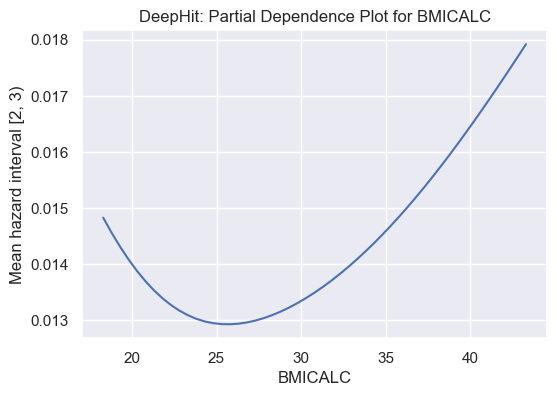

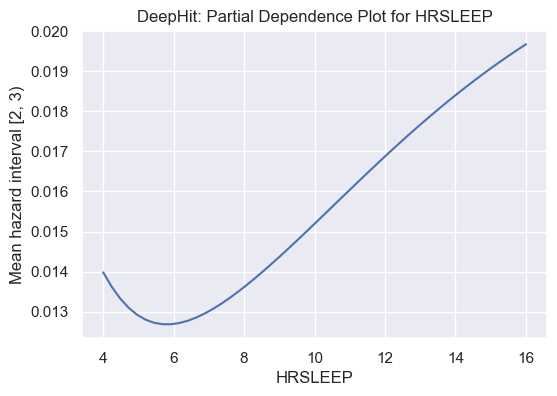

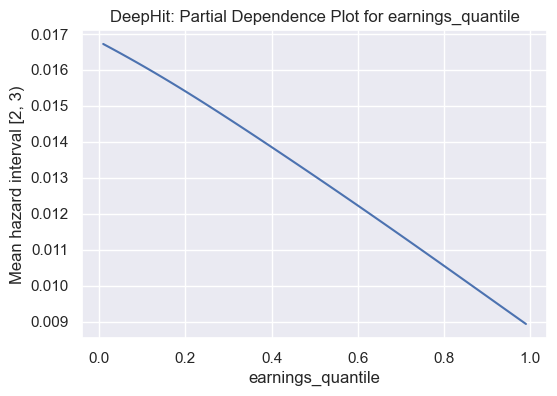

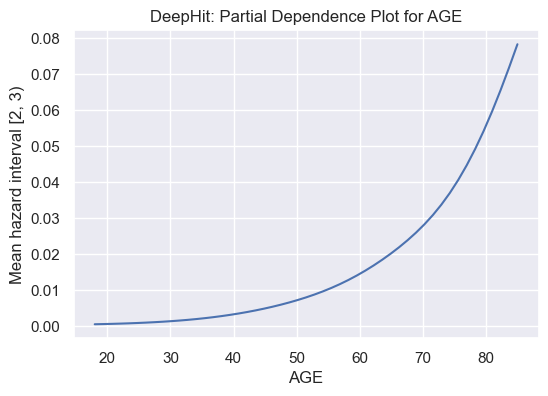

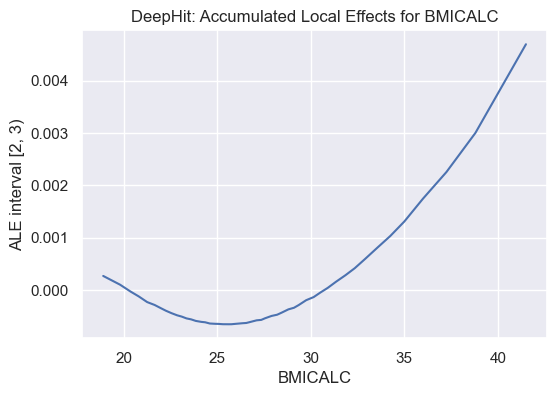

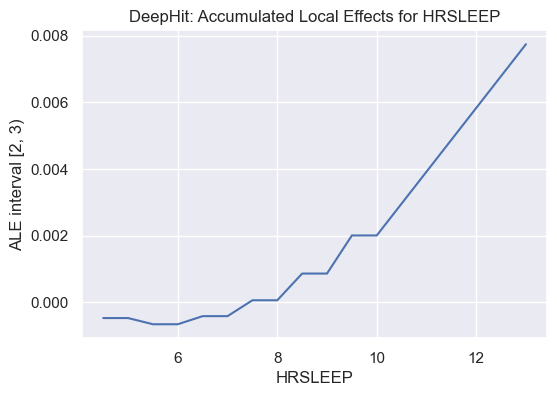

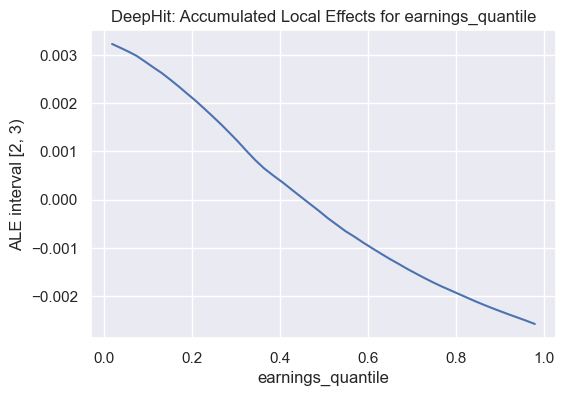

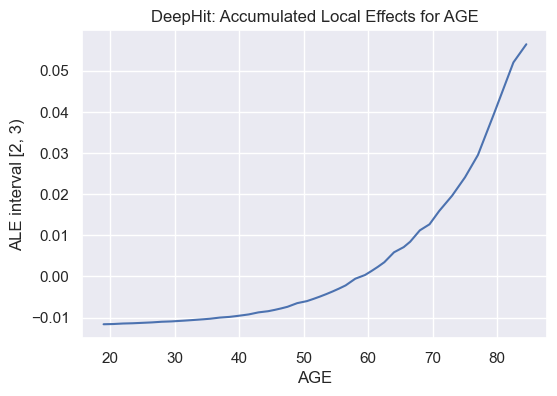

In [229]:
def plot_pdp(model, X_raw, X_scaled, variable, t1, t2):
    x_vals = np.linspace(X_raw[variable].quantile(0.01), X_raw[variable].quantile(0.99), 51)
    x_vals_scaled = np.linspace(np.quantile(X_scaled[:, X_raw.columns == variable], 0.01), np.quantile(X_scaled[:, X_raw.columns == variable], 0.99), 51)
    idx = X_raw.columns.get_loc(variable)
    y_vals = []

    for val in x_vals_scaled:
        X_copy = X_scaled.copy()
        X_copy[:, idx] = val
        surv_preds = model.predict_surv(X_copy)
        y_vals.append((surv_preds[:, t1] - surv_preds[:, t2]).mean())

    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel(variable)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"DeepHit: Partial Dependence Plot for {variable}")
    plt.show()

def plot_ale(model, X_raw, X_scaled, variable, t1, t2):
    df = pd.DataFrame(data = X_scaled, columns = X_raw.columns)
    df_sorted = df.sort_values(by=variable)
    quantiles = np.linspace(0.01, 0.99, 51)
    bin_edges = df[variable].quantile(quantiles).values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_edges_raw = X_raw[variable].quantile(quantiles).values
    bin_centers_raw = 0.5 * (bin_edges_raw[:-1] + bin_edges_raw[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (df[variable] >= lower) & (df[variable] < upper)
        df_bin = df[mask]
        
        if df_bin.empty:
            ale_values.append(0.0)
            continue
        
        df_low = df_bin.copy()
        df_high = df_bin.copy()
        df_low[variable] = lower
        df_high[variable] = upper

        pred_surv_high = model.predict_surv(df_high.to_numpy().astype('float32'))
        pred_surv_low = model.predict_surv(df_low.to_numpy().astype('float32'))
        pred_diff = (pred_surv_high[:,t1] - pred_surv_high[:,t2]) - (pred_surv_low[:,t1] - pred_surv_low[:,t2])
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers_raw, ale_centered)
    plt.xlabel(variable)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"DeepHit: Accumulated Local Effects for {variable}")
    plt.show()

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_pdp(model, X, X_scaled, var, 2, 3)

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_ale(model, X, X_scaled, var, 2, 3)

In [190]:
D2 = pd.read_csv("data/D2.csv")
D2["T"] = np.floor(D2["T"])

X_D2 = D2.drop(columns=["T", "event", "mu", "BMI_scaled", "SBP_scaled", "SD_SBP_scaled", "TCL_HDL_RATIO_scaled"])
T_D2 = D2["T"].to_numpy().astype('float32')
E_D2 = D2["event"].to_numpy().astype('bool')
mu_D2 = D2["mu"].to_numpy().astype('float32')

# Normalize features
scaler = MinMaxScaler()
X_D2_scaled = scaler.fit_transform(X_D2.to_numpy().astype('float32'))

# Train-test split
X_D2_train, X_D2_test, T_D2_train, T_D2_test, E_D2_train, E_D2_test, mu_D2_train, mu_D2_test = train_test_split(X_D2_scaled, T_D2, E_D2, mu_D2, test_size=0.2, random_state=0)
X_D2_train, X_D2_val, T_D2_train, T_D2_val, E_D2_train, E_D2_val = train_test_split(X_D2_train, T_D2_train, E_D2_train, test_size=0.2, random_state=0)

# Label transformation for DeepHit
num_durations = 11
labtrans = DeepHitSingle.label_transform(num_durations)
Y_D2_train = labtrans.fit_transform(T_D2_train, E_D2_train)
Y_D2_val = labtrans.transform(T_D2_val, E_D2_val)
Y_D2_test = labtrans.transform(T_D2_test, E_D2_test)

in_features = X_D2_train.shape[1]
net = tt.practical.MLPVanilla(
    in_features, [64, 32],
    out_features=labtrans.out_features,
    batch_norm=True,
    dropout=0.1,
    activation=torch.nn.Sigmoid
)
optimizer = tt.optim.Adam(lr=15e-3)
model_D2 = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts, alpha=0.2, sigma=0.3)

class CustomLRScheduler(Callback):
    def __init__(self, optimizer, decay=0.95, min_lr=1e-5):
        super().__init__()
        self.optimizer = optimizer
        self.decay = decay
        self.min_lr = min_lr

    def on_epoch_end(self):
            for i, param_group in enumerate(self.optimizer.param_groups):
                old_lr = param_group['lr']
                new_lr = max(self.min_lr, old_lr * self.decay)
                param_group['lr'] = new_lr
                #print(f"Reducing learning rate from {old_lr:.6f} to {new_lr:.6f}")

lr_callback = CustomLRScheduler(optimizer, decay=0.96)

callbacks = [
    lr_callback,
    tt.callbacks.EarlyStopping(patience=20),
]

start_time = time.time()
log = model_D2.fit(X_D2_train, Y_D2_train, batch_size=1024, epochs=50, verbose=True, callbacks=callbacks, val_data=(X_D2_val, Y_D2_val))
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

0:	[39s / 39s],		train_loss: 0.1403,	val_loss: 0.1265
1:	[34s / 1m:14s],		train_loss: 0.1272,	val_loss: 0.1248
2:	[35s / 1m:49s],		train_loss: 0.1267,	val_loss: 0.1250
3:	[35s / 2m:24s],		train_loss: 0.1263,	val_loss: 0.1259
4:	[35s / 2m:59s],		train_loss: 0.1261,	val_loss: 0.1248
5:	[38s / 3m:38s],		train_loss: 0.1259,	val_loss: 0.1244
6:	[37s / 4m:16s],		train_loss: 0.1257,	val_loss: 0.1256
7:	[36s / 4m:52s],		train_loss: 0.1256,	val_loss: 0.1238
8:	[35s / 5m:28s],		train_loss: 0.1254,	val_loss: 0.1253
9:	[35s / 6m:3s],		train_loss: 0.1254,	val_loss: 0.1240
10:	[37s / 6m:41s],		train_loss: 0.1252,	val_loss: 0.1239
11:	[34s / 7m:16s],		train_loss: 0.1252,	val_loss: 0.1255
12:	[36s / 7m:52s],		train_loss: 0.1251,	val_loss: 0.1239
13:	[41s / 8m:33s],		train_loss: 0.1252,	val_loss: 0.1239
14:	[39s / 9m:13s],		train_loss: 0.1251,	val_loss: 0.1235
15:	[45s / 9m:58s],		train_loss: 0.1251,	val_loss: 0.1239
16:	[42s / 10m:41s],		train_loss: 0.1250,	val_loss: 0.1244
17:	[41s / 11m:22s],		train

In [191]:
surv_preds = model_D2.predict_surv_df(X_D2_test)

ev = EvalSurv(surv_preds, T_D2_test, E_D2_test, censor_surv='km')
c_index = ev.concordance_td('antolini')
print(f"C-index: {c_index:.4f}")

time_grid = np.arange(12)
ibs = ev.integrated_brier_score(time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

p_interval = 1 - np.array(surv_preds)[-2,:]
in_interval = (E_D2_test == 1).astype(int)

logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9073019181271081
Integrated Brier Score: 0.07201736576125009
Log loss for interval [0, 10): 0.18875655922751886


In [192]:
pred = 1 - np.array(surv_preds)[-2,:]
mse = np.mean(np.square(np.log(mu_D2_test) - np.log(pred)))
dev = -2*np.sum(E_D2_test*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[E_D2_test==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:     0.17739451
Logistic deviance:            103921.421875
Kullback-Leibler divergence:  28468.29


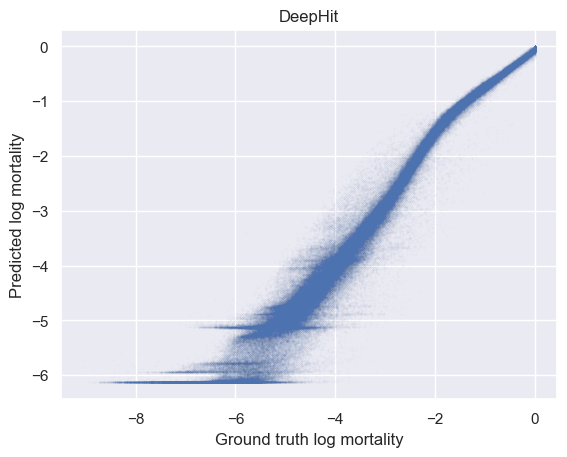

In [200]:
plt.plot(np.log(mu_D2_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("DeepHit")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

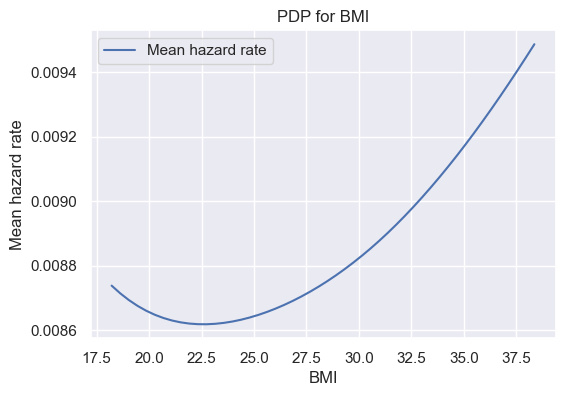

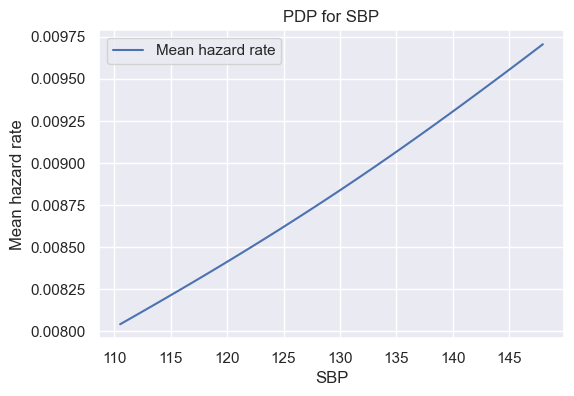

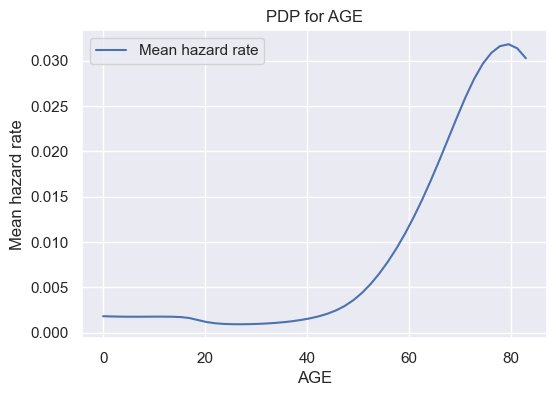

In [194]:
for var in ["BMI", "SBP", "AGE"]:
    plot_pdp(model_D2, X_D2, X_D2_scaled, var, 0, 10)